Found 21743 files belonging to 17 classes.
Found 5437 files belonging to 17 classes.
Confusion Matrix:
[[274  45   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [ 73 245   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 320   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   6   0 308   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 236  16  42   0   1   0   0   1   7   8   4   5   0]
 [  0   2   1   0  29 252  19   0   1   0   0   1   3   3   3   4   2]
 [  0   0   0   0  39  19 247   0   2   2   0   0   0   5   4   1   1]
 [  0   0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 317   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 320   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 320   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 320   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0   0   0   0

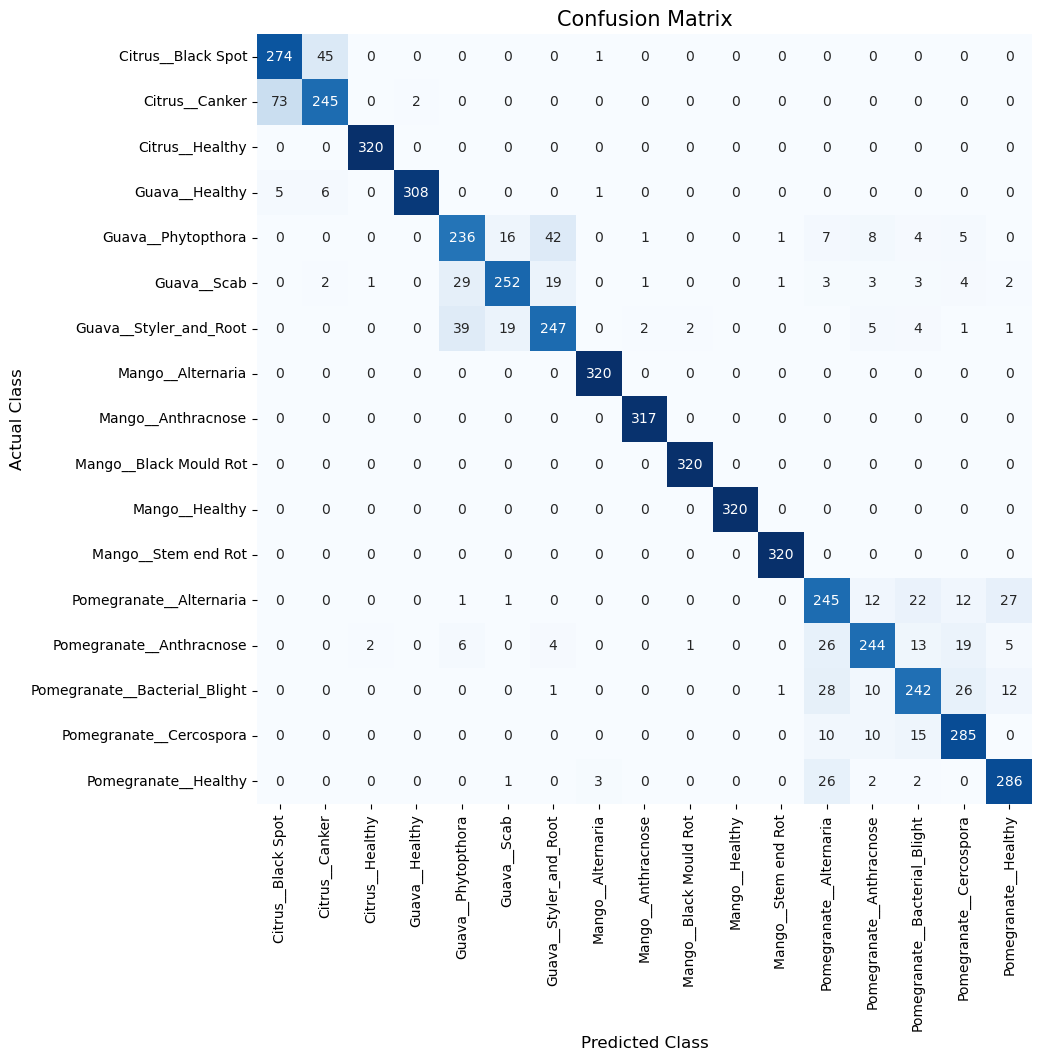

['scaler_model.pkl']

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load training and validation datasets
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="int",  # Change to integer labels for KNN
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

# Load pre-trained model for feature extraction
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Extract features from dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(feature_extractor(images).numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(training_set)
X_val, y_val = extract_features(validation_set)

# Dimensionality reduction
pca = PCA(n_components=50)  # Choose the number of components based on experimentation
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

# Hyperparameter tuning
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_knn = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_knn.predict(X_val_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)

# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the trained KNN model
import joblib
joblib.dump(best_knn, 'trained_plant_disease_knn_model.pkl')

# Save PCA and scaler
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler_model.pkl')


                               precision    recall  f1-score   support

           Citrus__Black Spot       0.78      0.86      0.82       320
               Citrus__Canker       0.82      0.77      0.79       320
              Citrus__Healthy       0.99      1.00      1.00       320
               Guava__Healthy       0.99      0.96      0.98       320
           Guava__Phytopthora       0.76      0.74      0.75       320
                  Guava__Scab       0.87      0.79      0.83       320
       Guava__Styler_and_Root       0.79      0.77      0.78       320
            Mango__Alternaria       0.98      1.00      0.99       320
           Mango__Anthracnose       0.99      1.00      0.99       317
       Mango__Black Mould Rot       0.99      1.00      1.00       320
               Mango__Healthy       1.00      1.00      1.00       320
          Mango__Stem end Rot       0.99      1.00      1.00       320
      Pomegranate__Alternaria       0.71      0.77      0.74       320
     

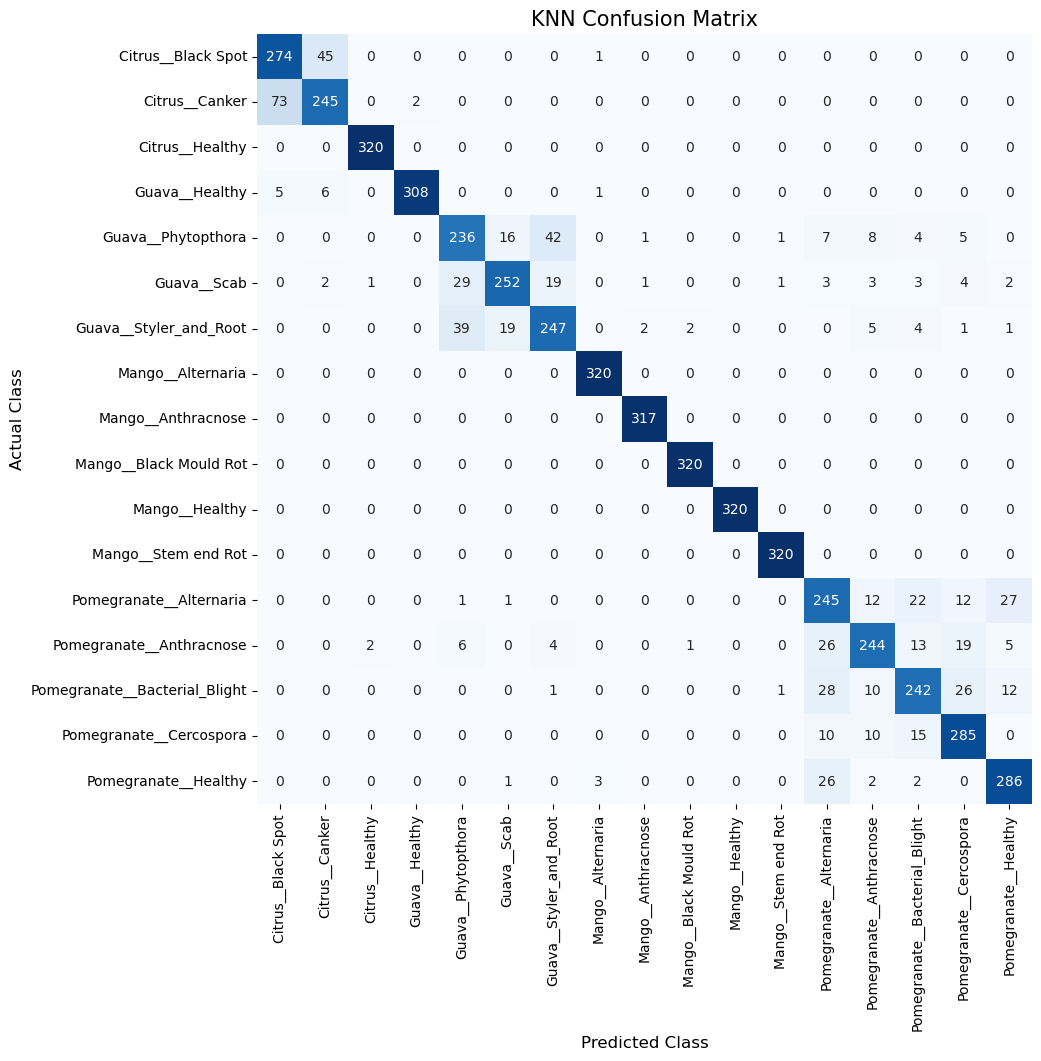

In [2]:
# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('KNN Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()